# AIRBNB PRICE PREDICTION - MODEL TRAINING PIPELINE
## Feature Engineering, Selection, Dimension Reduction & Model Training

**Models:**
1. Linear Regression (with regularization)
2. Random Forest
3. XGBoost

**Pipeline:**
- Advanced Feature Engineering
- Feature Selection (Multiple Methods)
- Dimension Reduction (PCA)
- Hyperparameter Tuning
- Model Evaluation & Comparison

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import subprocess

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create plots directory
os.makedirs('plots', exist_ok=True)

print("="*80)
print("AIRBNB PRICE PREDICTION - MODEL TRAINING")
print("="*80)

AIRBNB PRICE PREDICTION - MODEL TRAINING


In [45]:
#============================================================================
# STEP 1: LOAD DATA
#============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING DATA")
print("="*80)

X_train = np.load('processed_data/X_train_standard.npy')
X_val = np.load('processed_data/X_val_standard.npy')
X_test = np.load('processed_data/X_test_standard.npy')

y_train = np.load('processed_data/y_train.npy')
y_val = np.load('processed_data/y_val.npy')
y_test = np.load('processed_data/y_test.npy')

feature_names_df = pd.read_csv('processed_data/feature_names.csv')
feature_names = feature_names_df['feature'].tolist()

print(f"\n✓ Data loaded successfully!")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")
print(f"  Features: {len(feature_names)}")



STEP 1: LOADING DATA

✓ Data loaded successfully!
  Train: (12016, 102)
  Val:   (4006, 102)
  Test:  (4006, 102)
  Features: 102



📊 Plotting target distribution...


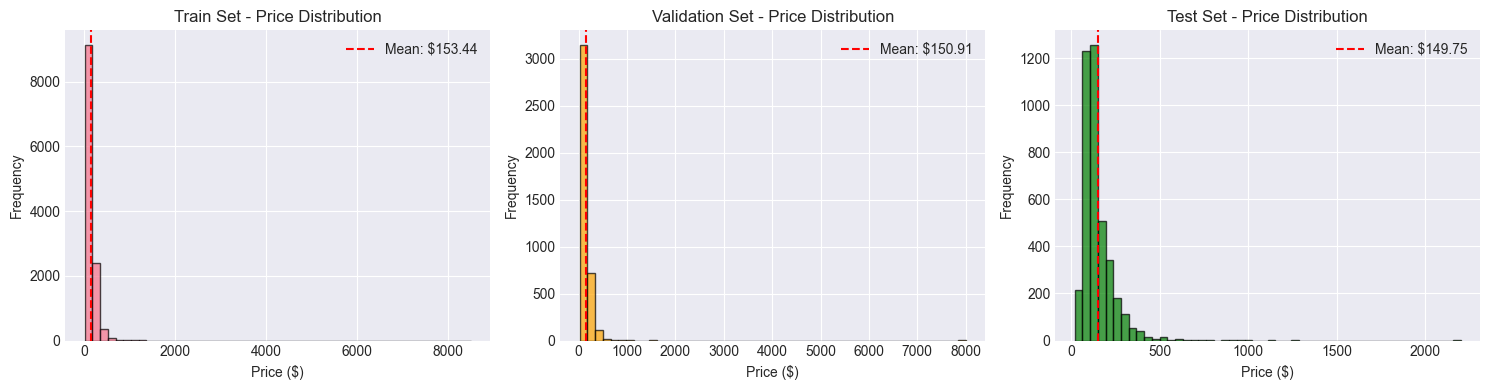

✓ Saved: plots/01_target_distribution.png


In [46]:
# VISUALIZE TARGET DISTRIBUTION
print("\n📊 Plotting target distribution...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_train, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Train Set - Price Distribution')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(y_train.mean(), color='r', linestyle='--', label=f'Mean: ${y_train.mean():.2f}')
axes[0].legend()

axes[1].hist(y_val, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Validation Set - Price Distribution')
axes[1].set_xlabel('Price ($)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(y_val.mean(), color='r', linestyle='--', label=f'Mean: ${y_val.mean():.2f}')
axes[1].legend()

axes[2].hist(y_test, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[2].set_title('Test Set - Price Distribution')
axes[2].set_xlabel('Price ($)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(y_test.mean(), color='r', linestyle='--', label=f'Mean: ${y_test.mean():.2f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('plots/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: plots/01_target_distribution.png")


In [ ]:
#============================================================================
# STEP 2: DATA LEAKAGE REMOVAL & FEATURE ENGINEERING
#============================================================================
print("\n" + "="*80)
print("STEP 2: DATA LEAKAGE REMOVAL & FEATURE ENGINEERING")
print("="*80)

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ============================================================================
# REMOVE DATA LEAKAGE FEATURES
# ============================================================================
print("\n🚨 Removing features with data leakage...")

leakage_features = [
    'avg_calendar_price',      # Directly leaks price information
    'min_calendar_price',      # Directly leaks price information
    'max_calendar_price',      # Directly leaks price information
]

dropped_leakage = [f for f in leakage_features if f in X_train_df.columns]
if dropped_leakage:
    X_train_df = X_train_df.drop(columns=dropped_leakage)
    X_val_df = X_val_df.drop(columns=dropped_leakage)
    X_test_df = X_test_df.drop(columns=dropped_leakage)
    for feat in dropped_leakage:
        print(f"  ✗ Dropped: {feat} (data leakage)")

# ============================================================================
# REMOVE UNNECESSARY HOST FEATURES
# ============================================================================
print("\n🧹 Removing unnecessary host features...")

unnecessary_host_features = [
    'host_name_target_encoded',           # Host name shouldn't affect price
    'host_location_target_encoded',       # Redundant with property location
    'host_neighbourhood_target_encoded',  # Redundant with property neighbourhood
    'host_has_profile_pic_True',          # Minimal impact on price
]

# Also remove all host_response_time features (low importance)
host_response_time_cols = [c for c in X_train_df.columns if 'host_response_time_' in c]
unnecessary_host_features.extend(host_response_time_cols)

dropped_host = [f for f in unnecessary_host_features if f in X_train_df.columns]
if dropped_host:
    X_train_df = X_train_df.drop(columns=dropped_host)
    X_val_df = X_val_df.drop(columns=dropped_host)
    X_test_df = X_test_df.drop(columns=dropped_host)
    for feat in dropped_host:
        print(f"  ✗ Dropped: {feat} (unnecessary)")

print(f"\n✓ Removed {len(dropped_leakage)} leakage features")
print(f"✓ Removed {len(dropped_host)} unnecessary host features")
print(f"✓ Remaining features: {X_train_df.shape[1]}")

# ============================================================================
# FEATURE ENGINEERING (WITHOUT LEAKAGE)
# ============================================================================
print("\n" + "="*80)
print("CREATING NEW FEATURES (NO LEAKAGE)")
print("="*80)

new_features = []

# 1. Reviews per day (engagement metric)
if 'number_of_reviews' in X_train_df.columns and 'host_tenure_days' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['reviews_per_day'] = df['number_of_reviews'] / (df['host_tenure_days'] + 1)
    new_features.append('reviews_per_day')
    print("✓ Created: reviews_per_day")

# 2. Availability ratio (booking flexibility)
if 'availability_365' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['availability_ratio'] = df['availability_365'] / 365.0
    new_features.append('availability_ratio')
    print("✓ Created: availability_ratio")

# 3. Review score average (overall quality)
review_cols = [c for c in X_train_df.columns if 'review_scores_' in c]
if len(review_cols) > 0:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['avg_review_score'] = df[review_cols].mean(axis=1)
    new_features.append('avg_review_score')
    print("✓ Created: avg_review_score")

# 4. Beds per bedroom (space efficiency)
if 'beds' in X_train_df.columns and 'bedrooms' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['beds_per_bedroom'] = df['beds'] / (df['bedrooms'] + 1)
    new_features.append('beds_per_bedroom')
    print("✓ Created: beds_per_bedroom")

# 5. Host experience (host quality metric)
if 'calculated_host_listings_count' in X_train_df.columns and 'host_tenure_years' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['host_experience'] = df['calculated_host_listings_count'] * df['host_tenure_years']
    new_features.append('host_experience')
    print("✓ Created: host_experience")

# 6. Space per person (capacity efficiency)
if 'accommodates' in X_train_df.columns and 'bedrooms' in X_train_df.columns:
    for df in [X_train_df, X_val_df, X_test_df]:
        df['space_per_person'] = df['bedrooms'] / (df['accommodates'] + 1)
    new_features.append('space_per_person')
    print("✓ Created: space_per_person")

# 7. Total amenities score (comfort level)
if 'amenities_count' in X_train_df.columns:
    amenity_cols = ['has_wifi', 'has_kitchen', 'has_tv', 'has_parking', 'has_ac', 'has_heating']
    existing_amenity_cols = [c for c in amenity_cols if c in X_train_df.columns]
    if existing_amenity_cols:
        for df in [X_train_df, X_val_df, X_test_df]:
            df['premium_amenities_score'] = df[existing_amenity_cols].sum(axis=1)
        new_features.append('premium_amenities_score')
        print("✓ Created: premium_amenities_score")

X_train_eng = X_train_df.values
X_val_eng = X_val_df.values
X_test_eng = X_test_df.values
feature_names_eng = X_train_df.columns.tolist()

print(f"\n✓ Feature engineering complete!")
print(f"  Original features: {len(feature_names)}")
print(f"  Dropped (leakage + unnecessary): {len(dropped_leakage) + len(dropped_host)}")
print(f"  New features added: {len(new_features)}")
print(f"  Total features: {len(feature_names_eng)}")


STEP 2: FEATURE ENGINEERING
✓ Created: price_per_person
✓ Created: reviews_per_day
✓ Created: availability_ratio
✓ Created: price_range
✓ Created: avg_review_score
✓ Created: beds_per_bedroom
✓ Created: host_experience

✓ Feature engineering complete!
  Original features: 102
  New features added: 7
  Total features: 109


In [48]:
#============================================================================
# STEP 3: FEATURE SELECTION
#============================================================================
print("\n" + "="*80)
print("STEP 3: FEATURE SELECTION")
print("="*80)

# F-statistic
print("  Computing F-statistic...")
f_selector = SelectKBest(f_regression, k='all')
f_selector.fit(X_train_eng, y_train)
f_scores = f_selector.scores_

# Mutual Information
print("  Computing Mutual Information...")
mi_scores = mutual_info_regression(X_train_eng, y_train, random_state=42)

# Random Forest Importance
print("  Computing Random Forest Importance...")
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_temp.fit(X_train_eng, y_train)
rf_importance = rf_temp.feature_importances_

# Combine scores
feature_scores_df = pd.DataFrame({
    'feature': feature_names_eng,
    'f_score': f_scores,
    'mi_score': mi_scores,
    'rf_importance': rf_importance
})

# Normalize and combine
for col in ['f_score', 'mi_score', 'rf_importance']:
    feature_scores_df[f'{col}_norm'] = (
        (feature_scores_df[col] - feature_scores_df[col].min()) /
        (feature_scores_df[col].max() - feature_scores_df[col].min())
    )

feature_scores_df['combined_score'] = (
    feature_scores_df['f_score_norm'] +
    feature_scores_df['mi_score_norm'] +
    feature_scores_df['rf_importance_norm']
) / 3

feature_scores_df = feature_scores_df.sort_values('combined_score', ascending=False)
feature_scores_df.to_csv('feature_importance_rankings.csv', index=False)



STEP 3: FEATURE SELECTION
  Computing F-statistic...
  Computing Mutual Information...
  Computing Random Forest Importance...



📊 Plotting feature importance...


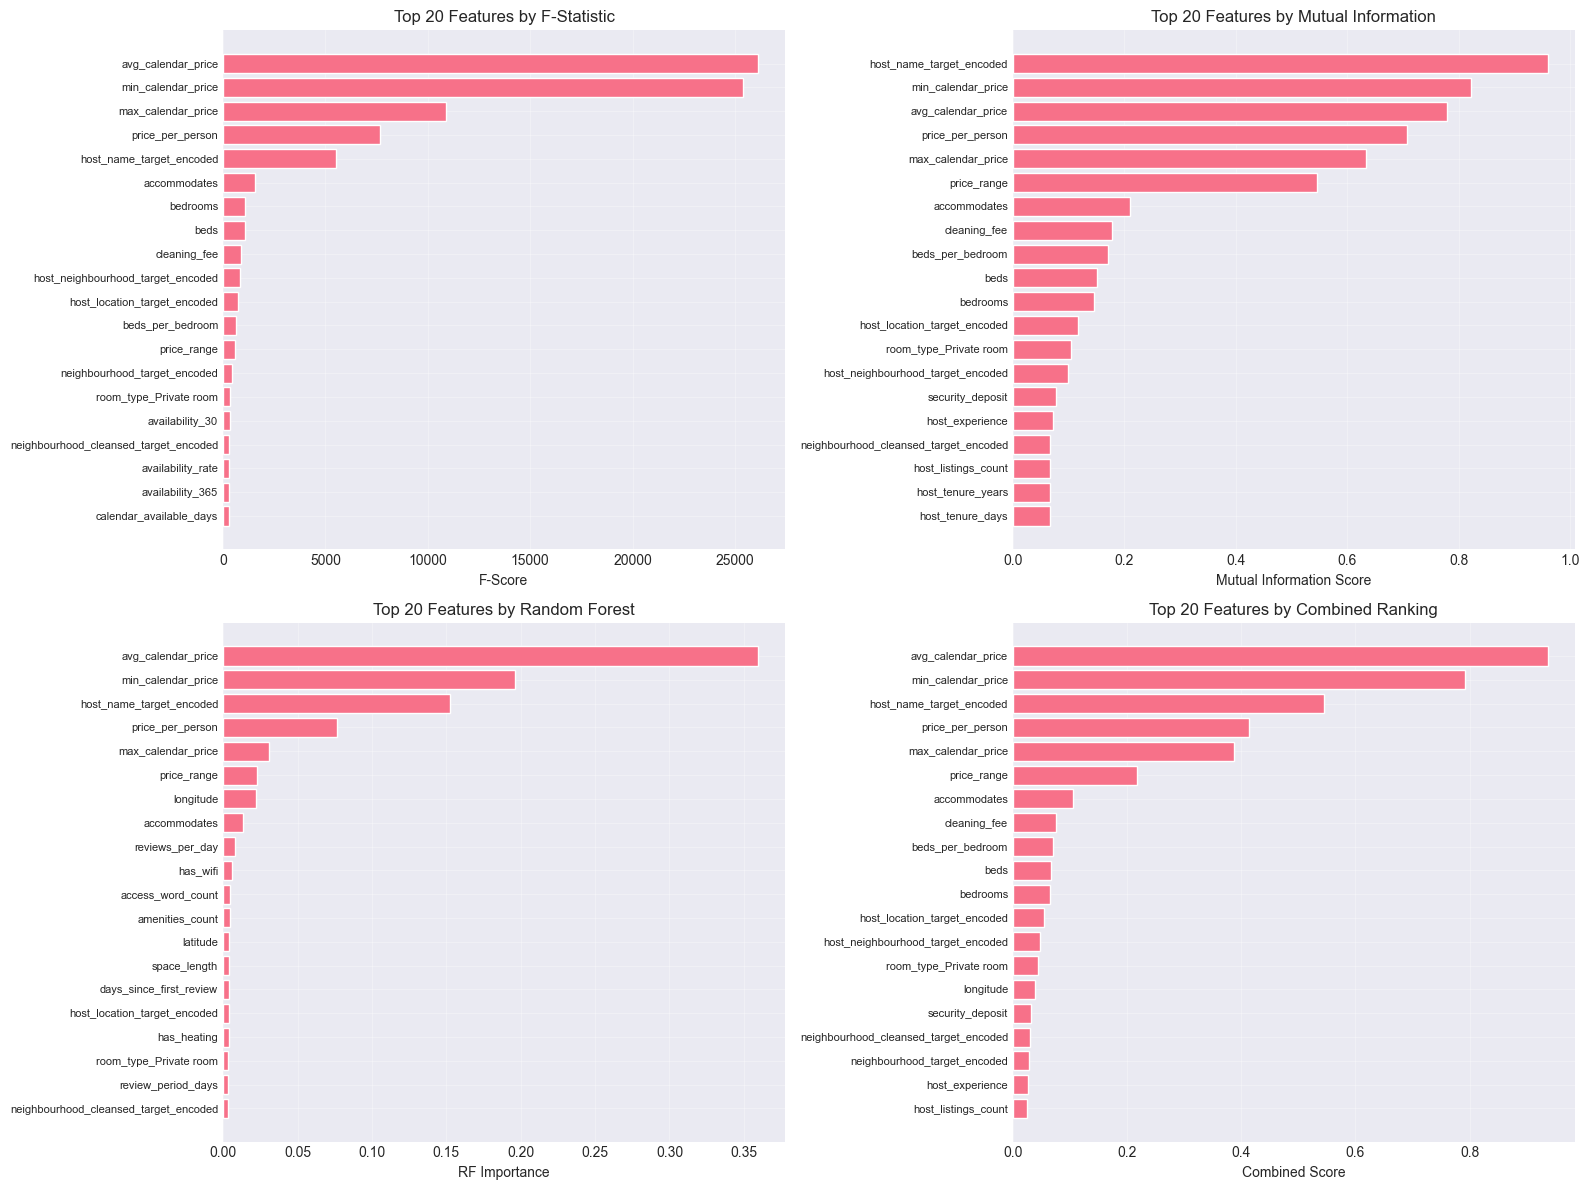

✓ Saved: plots/02_feature_importance.png


In [49]:
# VISUALIZE FEATURE IMPORTANCE
print("\n📊 Plotting feature importance...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F-Score
top_20_f = feature_scores_df.nlargest(20, 'f_score')
axes[0, 0].barh(range(len(top_20_f)), top_20_f['f_score'])
axes[0, 0].set_yticks(range(len(top_20_f)))
axes[0, 0].set_yticklabels(top_20_f['feature'], fontsize=8)
axes[0, 0].set_xlabel('F-Score')
axes[0, 0].set_title('Top 20 Features by F-Statistic')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# Mutual Information
top_20_mi = feature_scores_df.nlargest(20, 'mi_score')
axes[0, 1].barh(range(len(top_20_mi)), top_20_mi['mi_score'])
axes[0, 1].set_yticks(range(len(top_20_mi)))
axes[0, 1].set_yticklabels(top_20_mi['feature'], fontsize=8)
axes[0, 1].set_xlabel('Mutual Information Score')
axes[0, 1].set_title('Top 20 Features by Mutual Information')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3)

# Random Forest
top_20_rf = feature_scores_df.nlargest(20, 'rf_importance')
axes[1, 0].barh(range(len(top_20_rf)), top_20_rf['rf_importance'])
axes[1, 0].set_yticks(range(len(top_20_rf)))
axes[1, 0].set_yticklabels(top_20_rf['feature'], fontsize=8)
axes[1, 0].set_xlabel('RF Importance')
axes[1, 0].set_title('Top 20 Features by Random Forest')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3)

# Combined Score
top_20_combined = feature_scores_df.head(20)
axes[1, 1].barh(range(len(top_20_combined)), top_20_combined['combined_score'])
axes[1, 1].set_yticks(range(len(top_20_combined)))
axes[1, 1].set_yticklabels(top_20_combined['feature'], fontsize=8)
axes[1, 1].set_xlabel('Combined Score')
axes[1, 1].set_title('Top 20 Features by Combined Ranking')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/02_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: plots/02_feature_importance.png")


In [50]:
top_50_features = feature_scores_df.head(50)['feature'].tolist()

print(f"\n✓ Feature selection complete!")
print(f"\nTop 10 features:")
for i, row in feature_scores_df.head(10).iterrows():
    print(f"  {row['feature']}: {row['combined_score']:.4f}")

# Save feature sets
feature_sets = {
    'all_features': feature_names_eng,
    'top_50': top_50_features
}
with open('feature_sets.json', 'w') as f:
    json.dump(feature_sets, f, indent=2)

print("\n✓ Saved: feature_importance_rankings.csv")
print("✓ Saved: feature_sets.json")



✓ Feature selection complete!

Top 10 features:
  avg_calendar_price: 0.9372
  min_calendar_price: 0.7915
  host_name_target_encoded: 0.5451
  price_per_person: 0.4137
  max_calendar_price: 0.3871
  price_range: 0.2179
  accommodates: 0.1045
  cleaning_fee: 0.0751
  beds_per_bedroom: 0.0696
  beds: 0.0659

✓ Saved: feature_importance_rankings.csv
✓ Saved: feature_sets.json


In [51]:
#============================================================================
# STEP 4: CHECK GPU AVAILABILITY
#============================================================================
print("\n" + "="*80)
print("STEP 4: CHECKING GPU AVAILABILITY")
print("="*80)

try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    gpu_available = result.returncode == 0
    if gpu_available:
        print("🎮 GPU DETECTED!")
        print("   Checking XGBoost GPU support...")

        try:
            test_model = XGBRegressor(tree_method='hist', device='cuda', n_estimators=10)
            test_model.fit(X_train_eng[:100], y_train[:100])
            print("   ✓ XGBoost GPU support confirmed!")
            use_gpu = True
        except Exception as e:
            print(f"   ✗ GPU not supported: {str(e)[:80]}")
            print("   Using CPU instead")
            use_gpu = False
    else:
        print("💻 No GPU detected. Using CPU")
        use_gpu = False
except:
    print("💻 No GPU detected. Using CPU")
    use_gpu = False

print(f"\n✓ XGBoost will use: {'GPU' if use_gpu else 'CPU'}")


STEP 4: CHECKING GPU AVAILABILITY
🎮 GPU DETECTED!
   Checking XGBoost GPU support...
   ✓ XGBoost GPU support confirmed!

✓ XGBoost will use: GPU


In [52]:
#============================================================================
# STEP 5: TRAIN LINEAR REGRESSION
#============================================================================
print("\n" + "="*80)
print("1️⃣ TRAINING LINEAR REGRESSION (Ridge)")
print("="*80)

ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_grid = GridSearchCV(
    Ridge(random_state=42),
    ridge_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

print("\nTraining...")
ridge_grid.fit(X_train_eng, y_train)
print(f"✓ Best alpha: {ridge_grid.best_params_['alpha']}")

linear_model = ridge_grid.best_estimator_

# Evaluate
y_train_pred_lr = linear_model.predict(X_train_eng)
y_val_pred_lr = linear_model.predict(X_val_eng)
y_test_pred_lr = linear_model.predict(X_test_eng)

lr_results = {
    'train_mae': mean_absolute_error(y_train, y_train_pred_lr),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_lr)),
    'train_r2': r2_score(y_train, y_train_pred_lr),
    'val_mae': mean_absolute_error(y_val, y_val_pred_lr),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_lr)),
    'val_r2': r2_score(y_val, y_val_pred_lr),
    'val_mape': mean_absolute_percentage_error(y_val, y_val_pred_lr) * 100,
    'test_mae': mean_absolute_error(y_test, y_test_pred_lr),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_lr)),
    'test_r2': r2_score(y_test, y_test_pred_lr),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_lr) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN - MAE: ${lr_results['train_mae']:.2f}, RMSE: ${lr_results['train_rmse']:.2f}, R²: {lr_results['train_r2']:.4f}")
print(f"  VAL   - MAE: ${lr_results['val_mae']:.2f}, RMSE: ${lr_results['val_rmse']:.2f}, R²: {lr_results['val_r2']:.4f}")
print(f"  TEST  - MAE: ${lr_results['test_mae']:.2f}, RMSE: ${lr_results['test_rmse']:.2f}, R²: {lr_results['test_r2']:.4f}")

with open('linear_regression_model.pkl', 'wb') as f:
    pickle.dump(linear_model, f)
print("\n✓ Model saved: linear_regression_model.pkl")


1️⃣ TRAINING LINEAR REGRESSION (Ridge)

Training...
✓ Best alpha: 1000.0

📊 RESULTS:
  TRAIN - MAE: $33.73, RMSE: $73.74, R²: 0.7766
  VAL   - MAE: $37.17, RMSE: $65.96, R²: 0.8155
  TEST  - MAE: $38.31, RMSE: $63.19, R²: 0.5883

✓ Model saved: linear_regression_model.pkl


In [53]:
#============================================================================
# STEP 6: TRAIN RANDOM FOREST
#============================================================================
print("\n" + "="*80)
print("2️⃣ TRAINING RANDOM FOREST")
print("="*80)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5]
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    n_iter=30,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print("\nTraining (this may take a few minutes)...")
rf_random.fit(X_train_eng, y_train)
print(f"✓ Best params: {rf_random.best_params_}")

rf_model = rf_random.best_estimator_

# Evaluate
y_train_pred_rf = rf_model.predict(X_train_eng)
y_val_pred_rf = rf_model.predict(X_val_eng)
y_test_pred_rf = rf_model.predict(X_test_eng)

rf_results = {
    'train_mae': mean_absolute_error(y_train, y_train_pred_rf),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_rf)),
    'train_r2': r2_score(y_train, y_train_pred_rf),
    'val_mae': mean_absolute_error(y_val, y_val_pred_rf),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_rf)),
    'val_r2': r2_score(y_val, y_val_pred_rf),
    'val_mape': mean_absolute_percentage_error(y_val, y_val_pred_rf) * 100,
    'test_mae': mean_absolute_error(y_test, y_test_pred_rf),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    'test_r2': r2_score(y_test, y_test_pred_rf),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_rf) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN - MAE: ${rf_results['train_mae']:.2f}, RMSE: ${rf_results['train_rmse']:.2f}, R²: {rf_results['train_r2']:.4f}")
print(f"  VAL   - MAE: ${rf_results['val_mae']:.2f}, RMSE: ${rf_results['val_rmse']:.2f}, R²: {rf_results['val_r2']:.4f}")
print(f"  TEST  - MAE: ${rf_results['test_mae']:.2f}, RMSE: ${rf_results['test_rmse']:.2f}, R²: {rf_results['test_r2']:.4f}")

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("\n✓ Model saved: random_forest_model.pkl")



2️⃣ TRAINING RANDOM FOREST

Training (this may take a few minutes)...
✓ Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 20}

📊 RESULTS:
  TRAIN - MAE: $14.29, RMSE: $55.90, R²: 0.8717
  VAL   - MAE: $31.93, RMSE: $77.75, R²: 0.7436
  TEST  - MAE: $31.74, RMSE: $56.88, R²: 0.6665

✓ Model saved: random_forest_model.pkl


In [54]:
#============================================================================
# STEP 7: TRAIN XGBOOST
# ============================================================================
print("\n" + "="*80)
print(f"3️⃣ TRAINING XGBOOST ({'GPU' if use_gpu else 'CPU'})")
print("="*80)

xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

if use_gpu:
    xgb_base = XGBRegressor(
        random_state=42,
        tree_method='hist',
        device='cuda',
        n_jobs=1
    )
else:
    xgb_base = XGBRegressor(
        random_state=42,
        tree_method='hist',
        n_jobs=-1
    )

xgb_random = RandomizedSearchCV(
    xgb_base,
    xgb_params,
    n_iter=30,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print("\nTraining (this may take a few minutes)...")
xgb_random.fit(X_train_eng, y_train)
print(f"✓ Best params: {xgb_random.best_params_}")

xgb_model = xgb_random.best_estimator_

# Evaluate
y_train_pred_xgb = xgb_model.predict(X_train_eng)
y_val_pred_xgb = xgb_model.predict(X_val_eng)
y_test_pred_xgb = xgb_model.predict(X_test_eng)

xgb_results = {
    'train_mae': mean_absolute_error(y_train, y_train_pred_xgb),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)),
    'train_r2': r2_score(y_train, y_train_pred_xgb),
    'val_mae': mean_absolute_error(y_val, y_val_pred_xgb),
    'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred_xgb)),
    'val_r2': r2_score(y_val, y_val_pred_xgb),
    'val_mape': mean_absolute_percentage_error(y_val, y_val_pred_xgb) * 100,
    'test_mae': mean_absolute_error(y_test, y_test_pred_xgb),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
    'test_r2': r2_score(y_test, y_test_pred_xgb),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_xgb) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN - MAE: ${xgb_results['train_mae']:.2f}, RMSE: ${xgb_results['train_rmse']:.2f}, R²: {xgb_results['train_r2']:.4f}")
print(f"  VAL   - MAE: ${xgb_results['val_mae']:.2f}, RMSE: ${xgb_results['val_rmse']:.2f}, R²: {xgb_results['val_r2']:.4f}")
print(f"  TEST  - MAE: ${xgb_results['test_mae']:.2f}, RMSE: ${xgb_results['test_rmse']:.2f}, R²: {xgb_results['test_r2']:.4f}")

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("\n✓ Model saved: xgboost_model.pkl")



3️⃣ TRAINING XGBOOST (GPU)

Training (this may take a few minutes)...
✓ Best params: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}

📊 RESULTS:
  TRAIN - MAE: $17.97, RMSE: $26.32, R²: 0.9715
  VAL   - MAE: $33.06, RMSE: $123.38, R²: 0.3544
  TEST  - MAE: $31.64, RMSE: $60.77, R²: 0.6193

✓ Model saved: xgboost_model.pkl


In [55]:
# ============================================================================
# STEP 8: COMPARE ALL MODELS
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON - ALL SETS (Train/Val/Test)")
print("="*80)

all_results = {
    'Linear_Regression': lr_results,
    'Random_Forest': rf_results,
    'XGBoost': xgb_results
}

comparison_df = pd.DataFrame(all_results).T
comparison_df = comparison_df.sort_values('test_mae')

print("\n📊 ALL RESULTS:")
print("\n" + "-"*80)
print(f"{'Model':<20} {'Train MAE':<12} {'Val MAE':<12} {'Test MAE':<12} {'Test R²':<10}")
print("-"*80)
for model_name in comparison_df.index:
    train_mae = comparison_df.loc[model_name, 'train_mae']
    val_mae = comparison_df.loc[model_name, 'val_mae']
    test_mae = comparison_df.loc[model_name, 'test_mae']
    test_r2 = comparison_df.loc[model_name, 'test_r2']
    print(f"{model_name:<20} ${train_mae:<11.2f} ${val_mae:<11.2f} ${test_mae:<11.2f} {test_r2:<10.4f}")
print("-"*80)

comparison_df.to_csv('model_comparison_all_sets.csv')
print("\n✓ Saved: model_comparison_all_sets.csv")

best_model_name = comparison_df['test_mae'].idxmin()
best_test_mae = comparison_df.loc[best_model_name, 'test_mae']

print("\n" + "="*80)
print("🏆 BEST MODEL (Based on Test MAE)")
print("="*80)
print(f"Model: {best_model_name}")
print(f"Test MAE: ${best_test_mae:.2f}")
print(f"Test RMSE: ${comparison_df.loc[best_model_name, 'test_rmse']:.2f}")
print(f"Test R²: {comparison_df.loc[best_model_name, 'test_r2']:.4f}")
print(f"Test MAPE: {comparison_df.loc[best_model_name, 'test_mape']:.2f}%")



MODEL COMPARISON - ALL SETS (Train/Val/Test)

📊 ALL RESULTS:

--------------------------------------------------------------------------------
Model                Train MAE    Val MAE      Test MAE     Test R²   
--------------------------------------------------------------------------------
XGBoost              $17.97       $33.06       $31.64       0.6193    
Random_Forest        $14.29       $31.93       $31.74       0.6665    
Linear_Regression    $33.73       $37.17       $38.31       0.5883    
--------------------------------------------------------------------------------

✓ Saved: model_comparison_all_sets.csv

🏆 BEST MODEL (Based on Test MAE)
Model: XGBoost
Test MAE: $31.64
Test RMSE: $60.77
Test R²: 0.6193
Test MAPE: 24.12%



📊 Plotting model comparison...


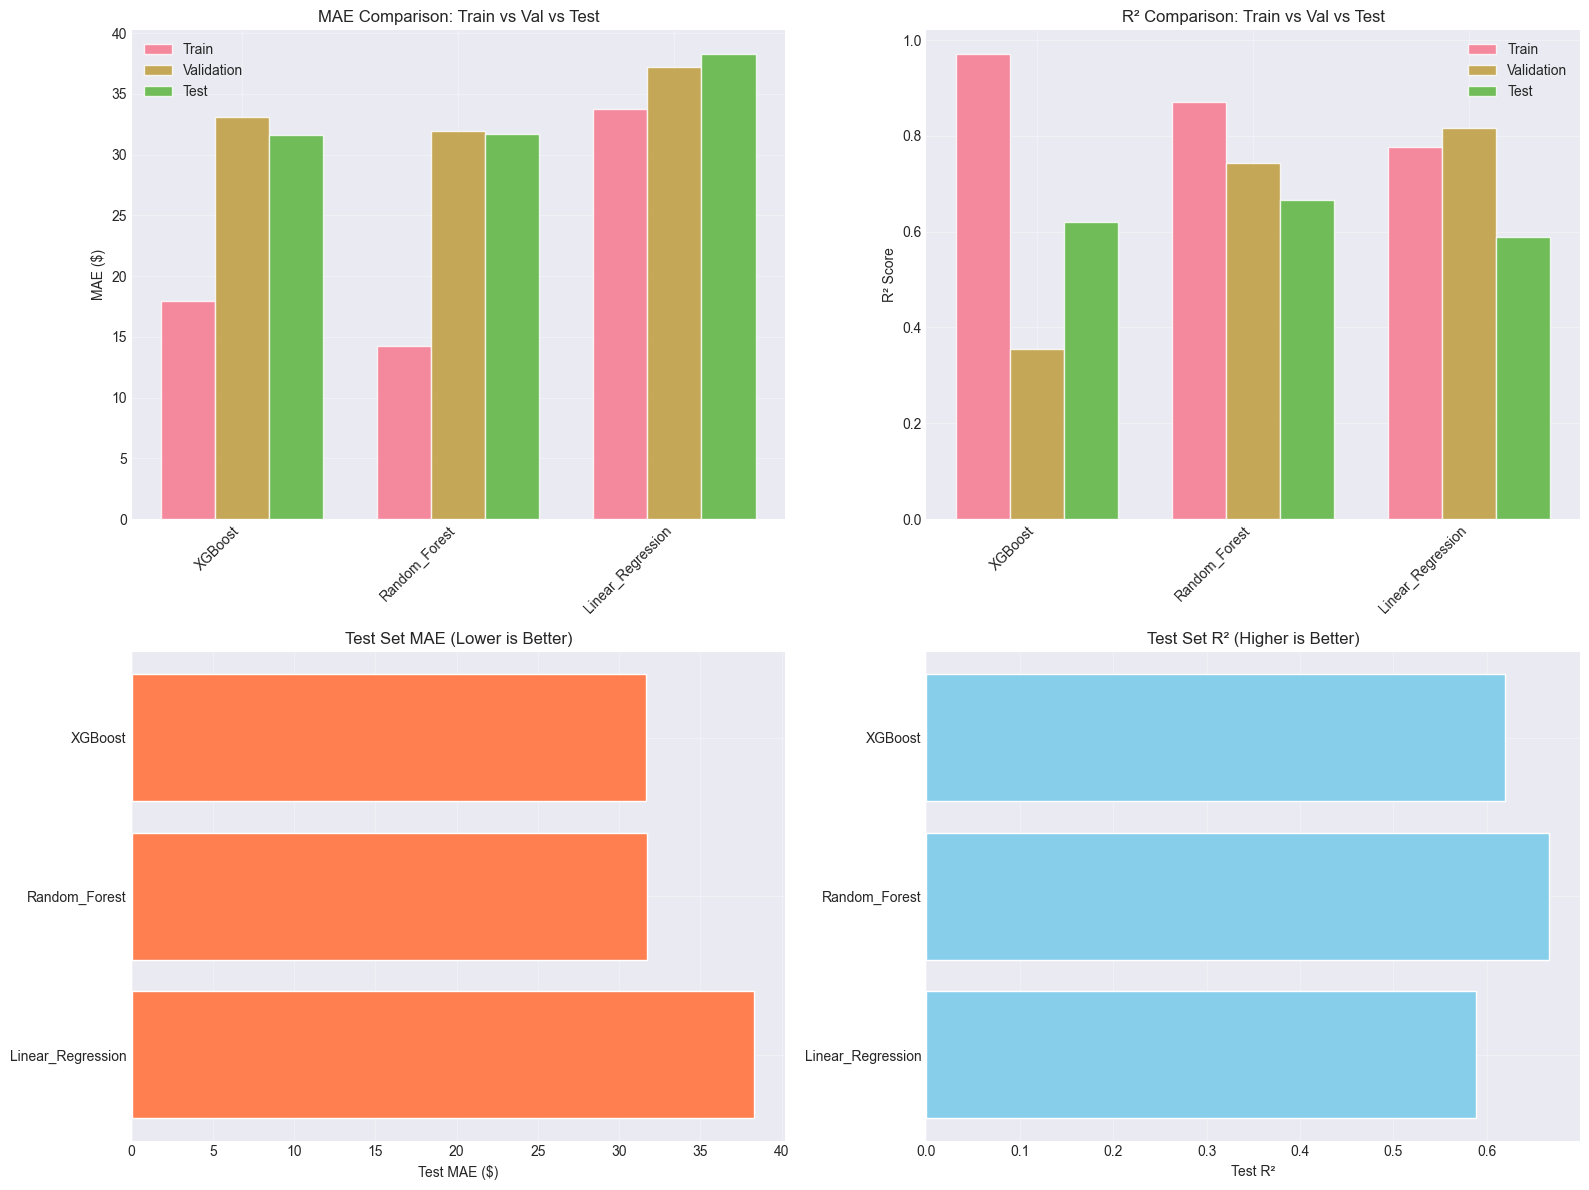

✓ Saved: plots/03_model_comparison_all_sets.png


In [56]:
# VISUALIZE MODEL COMPARISON
print("\n📊 Plotting model comparison...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = comparison_df.index
x = np.arange(len(models))
width = 0.25

# MAE comparison (Train/Val/Test)
axes[0, 0].bar(x - width, comparison_df['train_mae'], width, label='Train', alpha=0.8)
axes[0, 0].bar(x, comparison_df['val_mae'], width, label='Validation', alpha=0.8)
axes[0, 0].bar(x + width, comparison_df['test_mae'], width, label='Test', alpha=0.8)
axes[0, 0].set_ylabel('MAE ($)')
axes[0, 0].set_title('MAE Comparison: Train vs Val vs Test')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# R² comparison (Train/Val/Test)
axes[0, 1].bar(x - width, comparison_df['train_r2'], width, label='Train', alpha=0.8)
axes[0, 1].bar(x, comparison_df['val_r2'], width, label='Validation', alpha=0.8)
axes[0, 1].bar(x + width, comparison_df['test_r2'], width, label='Test', alpha=0.8)
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('R² Comparison: Train vs Val vs Test')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Test MAE only (sorted)
axes[1, 0].barh(models, comparison_df['test_mae'], color='coral')
axes[1, 0].set_xlabel('Test MAE ($)')
axes[1, 0].set_title('Test Set MAE (Lower is Better)')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3)

# Test R² only (sorted)
axes[1, 1].barh(models, comparison_df['test_r2'], color='skyblue')
axes[1, 1].set_xlabel('Test R²')
axes[1, 1].set_title('Test Set R² (Higher is Better)')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/03_model_comparison_all_sets.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: plots/03_model_comparison_all_sets.png")



📊 Plotting best model predictions...


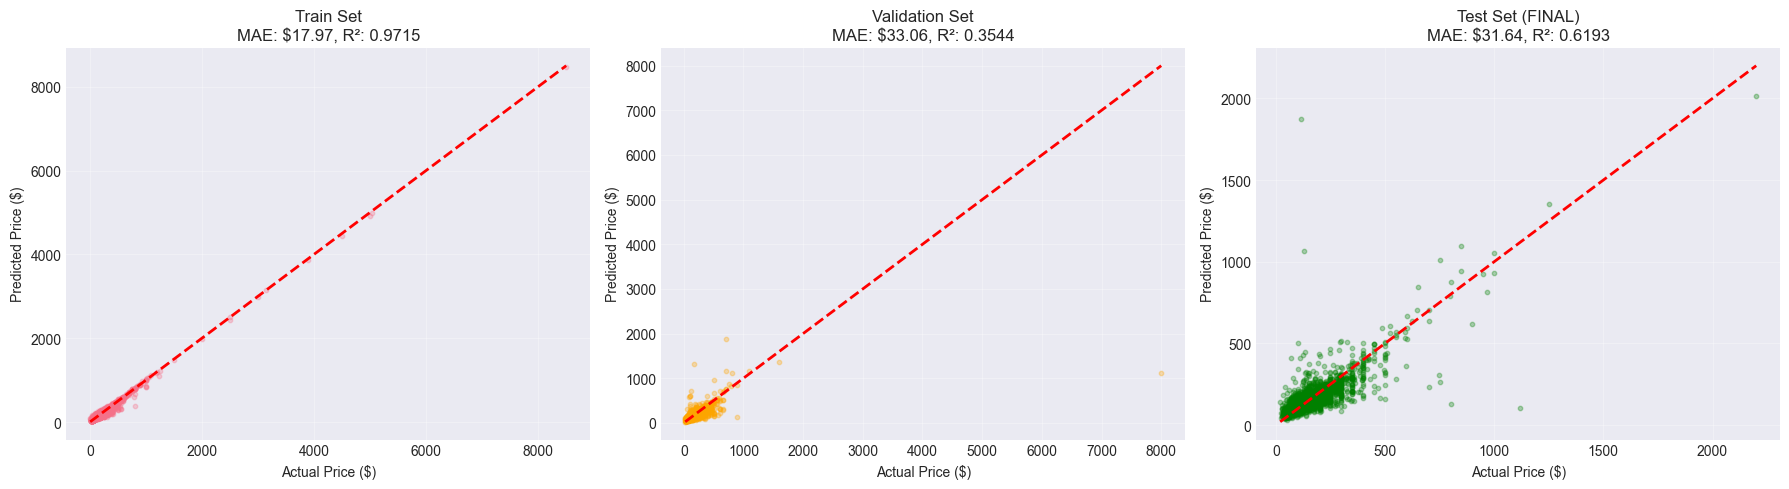

✓ Saved: plots/04_best_model_XGBoost_predictions.png


In [57]:
# VISUALIZE BEST MODEL PREDICTIONS
print("\n📊 Plotting best model predictions...")

# Get predictions for best model
if best_model_name == 'Linear_Regression':
    best_y_train_pred = y_train_pred_lr
    best_y_val_pred = y_val_pred_lr
    best_y_test_pred = y_test_pred_lr
elif best_model_name == 'Random_Forest':
    best_y_train_pred = y_train_pred_rf
    best_y_val_pred = y_val_pred_rf
    best_y_test_pred = y_test_pred_rf
else:  # XGBoost
    best_y_train_pred = y_train_pred_xgb
    best_y_val_pred = y_val_pred_xgb
    best_y_test_pred = y_test_pred_xgb

# Predictions vs Actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train
axes[0].scatter(y_train, best_y_train_pred, alpha=0.3, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Train Set\nMAE: ${comparison_df.loc[best_model_name, "train_mae"]:.2f}, R²: {comparison_df.loc[best_model_name, "train_r2"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Validation
axes[1].scatter(y_val, best_y_val_pred, alpha=0.3, s=10, color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_title(f'Validation Set\nMAE: ${comparison_df.loc[best_model_name, "val_mae"]:.2f}, R²: {comparison_df.loc[best_model_name, "val_r2"]:.4f}')
axes[1].grid(True, alpha=0.3)

# Test
axes[2].scatter(y_test, best_y_test_pred, alpha=0.3, s=10, color='green')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Price ($)')
axes[2].set_ylabel('Predicted Price ($)')
axes[2].set_title(f'Test Set (FINAL)\nMAE: ${comparison_df.loc[best_model_name, "test_mae"]:.2f}, R²: {comparison_df.loc[best_model_name, "test_r2"]:.4f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
safe_model_name = best_model_name.replace(' ', '_').replace('/', '_')
plt.savefig(f'plots/04_best_model_{safe_model_name}_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: plots/04_best_model_{safe_model_name}_predictions.png")



📊 Plotting residuals...


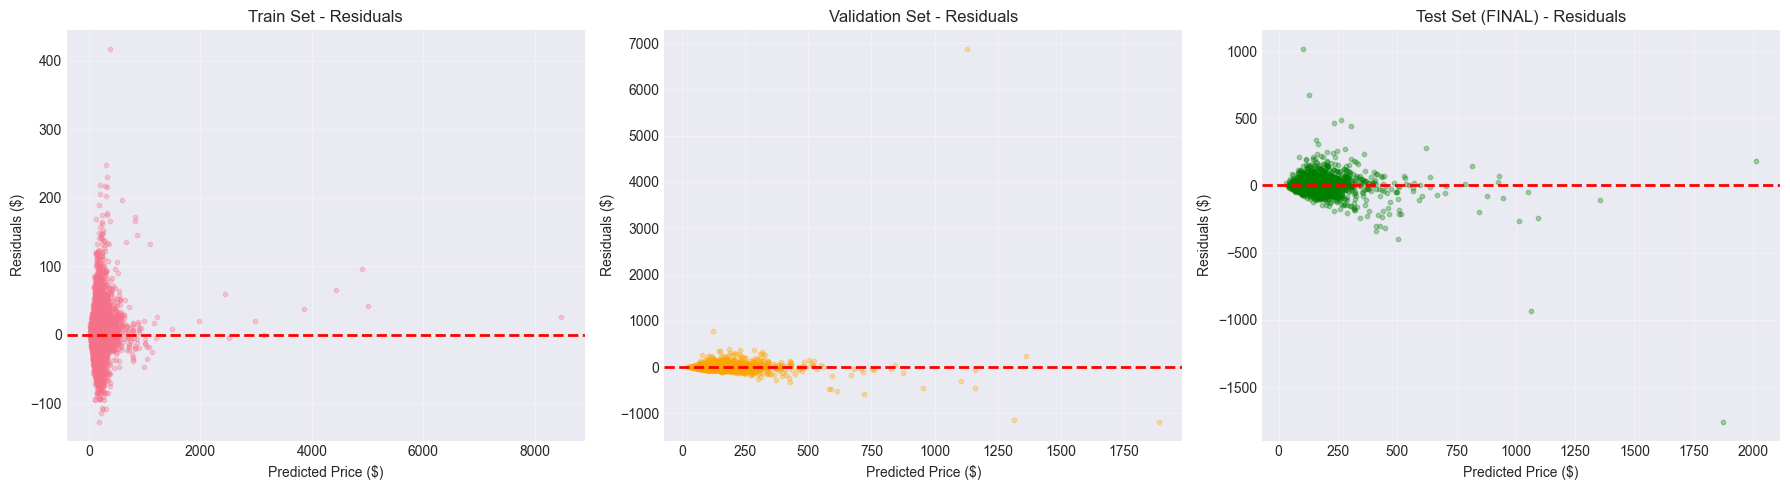

✓ Saved: plots/05_best_model_XGBoost_residuals.png


In [58]:
# VISUALIZE RESIDUALS
print("\n📊 Plotting residuals...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

train_residuals = y_train - best_y_train_pred
val_residuals = y_val - best_y_val_pred
test_residuals = y_test - best_y_test_pred

axes[0].scatter(best_y_train_pred, train_residuals, alpha=0.3, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Residuals ($)')
axes[0].set_title('Train Set - Residuals')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(best_y_val_pred, val_residuals, alpha=0.3, s=10, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Validation Set - Residuals')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(best_y_test_pred, test_residuals, alpha=0.3, s=10, color='green')
axes[2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Predicted Price ($)')
axes[2].set_ylabel('Residuals ($)')
axes[2].set_title('Test Set (FINAL) - Residuals')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'plots/05_best_model_{safe_model_name}_residuals.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: plots/05_best_model_{safe_model_name}_residuals.png")


In [59]:
print("✅ TRAINING COMPLETE!")
print("="*80)
print("\nAll models trained and saved successfully!")
print("All visualizations created and saved to 'plots/' directory!")
print("\nGenerated plots:")
print("  1. plots/01_target_distribution.png")
print("  2. plots/02_feature_importance.png")
print("  3. plots/03_model_comparison_all_sets.png")
print(f"  4. plots/04_best_model_{safe_model_name}_predictions.png")
print(f"  5. plots/05_best_model_{safe_model_name}_residuals.png")



✅ TRAINING COMPLETE!

All models trained and saved successfully!
All visualizations created and saved to 'plots/' directory!

Generated plots:
  1. plots/01_target_distribution.png
  2. plots/02_feature_importance.png
  3. plots/03_model_comparison_all_sets.png
  4. plots/04_best_model_XGBoost_predictions.png
  5. plots/05_best_model_XGBoost_residuals.png
